In [1]:
# Yomitoku Clientの使用例
# このノートブックでは、Yomitoku Clientを使用してSageMaker Yomitokuの出力を
# 様々な形式（CSV、Markdown、HTML、JSON）に変換する方法を示します

# 必要なライブラリのインポート
from yomitoku_client import YomitokuClient  # メインのクライアントクラス
from yomitoku_client.parsers.sagemaker_parser import SageMakerParser  # SageMakerの出力をパースするクラス
from yomitoku_client import pdf_sample, image_sample  # サンプルデータ（PDFと画像）
from pprint import pprint  # きれいな出力のため
import pandas as pd  # データフレーム操作用

In [2]:
# クライアントとパーサーのインスタンスを作成
# YomitokuClient: 様々な形式への変換を行うメインクラス
# SageMakerParser: SageMaker Yomitokuの出力をPydanticモデルにパースする
client = YomitokuClient()
parser = SageMakerParser()

## 画像サンプルの処理
### 画像から抽出されたテキストとレイアウト情報を様々な形式に変換

In [3]:
# 画像サンプルデータをパース
# parse_dict: SageMaker Yomitokuの辞書形式の出力をPydanticモデルに変換
img_data = parser.parse_dict(image_sample)

# 様々な出力形式に変換して最初の100文字を表示
# CSV形式: カンマ区切りのテキスト形式
print("CSV形式の出力（最初の100文字）:")
print(client.convert_to_format(img_data, 'csv')[:100])

# Markdown形式: 見出しや強調表示を含むMarkdown記法
print("\nMarkdown形式の出力（最初の100文字）:")
print(client.convert_to_format(img_data, 'md')[:100])

# HTML形式: ウェブページで表示可能なHTML形式
print("\nHTML形式の出力（最初の100文字）:")
print(client.convert_to_format(img_data, 'html')[:100])

# JSON形式: 構造化されたJSON形式
print("\nJSON形式の出力（最初の100文字）:")
print(client.convert_to_format(img_data, 'json')[:100])

CSV形式の出力（最初の100文字）:
--- Document 1 ---
"TELEWORK
LEWORK"

"ORK
LEWORK TELEWORK"

"テレワークのさらなる普及・定着に向け「テレワーク月間」を実施します!

Markdown形式の出力（最初の100文字）:
--- Document 1 ---
TELEWORK<br>LEWORK
ORK<br>LEWORK TELEWORK
テレワークのさらなる普及・定着に向け「テレワーク月間」を実施します\!<br>

HTML形式の出力（最初の100文字）:
--- Document 1 ---
<div><p>TELEWORK<br/>LEWORK</p>
<p>ORK<br/>LEWORK TELEWORK</p>
<p>テレワークのさらなる普及・定着

JSON形式の出力（最初の100文字）:
--- Document 1 ---
{
    "figures": [
        {
            "box": [
                724,
          


## PDFサンプルの処理
### PDF文書から抽出されたテキストとレイアウト情報を様々な形式に変換

In [4]:
# PDFサンプルデータをパース
# PDFの場合も同様にSageMaker Yomitokuの出力をパースして変換
pdf_data = parser.parse_dict(pdf_sample)

# 各形式に変換して最初の100文字を表示
print("CSV形式の出力（最初の100文字）:")
print(client.convert_to_format(pdf_data, 'csv')[:100])

print("\nMarkdown形式の出力（最初の100文字）:")
print(client.convert_to_format(pdf_data, 'md')[:100])

print("\nHTML形式の出力（最初の100文字）:")
print(client.convert_to_format(pdf_data, 'html')[:100])

print("\nJSON形式の出力（最初の100文字）:")
print(client.convert_to_format(pdf_data, 'json')[:100])

CSV形式の出力（最初の100文字）:
--- Document 1 ---
もっと知りたい!現在·未来のくらしと生活の情報誌

総務省

2024 年11月号

"Ministry of
Internal Affairs an

Markdown形式の出力（最初の100文字）:
--- Document 1 ---
もっと知りたい\!現在·未来のくらしと生活の情報誌
# 総務省
2024 年11月号
Ministry of<br>Internal Affairs and<br

HTML形式の出力（最初の100文字）:
--- Document 1 ---
<div><p>もっと知りたい!現在·未来のくらしと生活の情報誌</p>
<h1>総務省</h1>
<p>2024 年11月号</p>
<p>Ministry o

JSON形式の出力（最初の100文字）:
--- Document 1 ---
{
    "figures": [
        {
            "box": [
                1475,
         


In [5]:
# ビジュアライゼーション用のクラスをインポート
# ChartVisualizer: グラフやチャートの可視化
# TableVisualizer: テーブルデータの可視化
# DocumentVisualizer: 文書レイアウトの可視化（バウンディングボックス表示など）
from yomitoku_client.visualizers import (
    ChartVisualizer,
    TableVisualizer,
    DocumentVisualizer
)

In [6]:
# 画像ファイルのパスを指定
# DocumentVisualizerのインスタンスを作成
image = "./image.png"  # 可視化する画像ファイル
doc_viz = DocumentVisualizer()  # 文書レイアウトを可視化するクラス

In [7]:
# DocumentVisualizerを使用してレイアウトの詳細を可視化
# visualize: 画像とパースされたデータを受け取り、バウンディングボックスを描画
# type='layout_detail': レイアウトの詳細（テキスト、図、表の位置）を表示
doc_viz = DocumentVisualizer()
result_img = doc_viz.visualize((image, img_data), type='layout_detail')

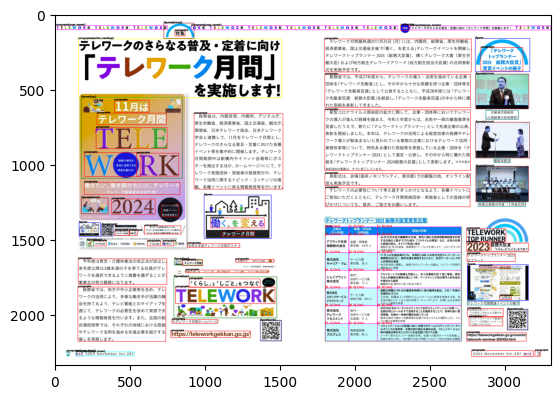

In [8]:
# 可視化結果を表示
# matplotlibとOpenCVを使用して、バウンディングボックス付きの画像を表示
import matplotlib.pyplot as plt
import cv2

# result_img: バウンディングボックスが描画された画像
plt.imshow(result_img)
plt.show()

## テーブルビジュアライザーのデモ
### 抽出されたテーブルデータを様々な形式で可視化・エクスポート

In [9]:
# テーブルデータの確認と変換
# TableVisualizerを使用してテーブルデータを処理
table_viz = TableVisualizer()

# 画像データからテーブルを探す
if hasattr(img_data[0], 'tables') and img_data[0].tables:
    print(f"画像サンプルから {len(img_data[0].tables)} 個のテーブルを発見")
    
    # 最初のテーブルを取得
    table_obj = img_data[0].tables[0]
    print(f"テーブルサイズ: {table_obj.n_row} 行 x {table_obj.n_col} 列")
    
    # テーブルの最大行数と列数を取得
    max_row = max(cell.row for cell in table_obj.cells)
    max_col = max(cell.col for cell in table_obj.cells)
    
    # 2次元配列を作成してセルデータを格納
    table_array = [[""] * max_col for _ in range(max_row)]
    for cell in table_obj.cells:
        # セルの位置は1ベースなので、0ベースに変換
        row_idx, col_idx = cell.row - 1, cell.col - 1 
        table_array[row_idx][col_idx] = cell.contents
    
    # pandas DataFrameに変換
    col_names = [f"Column_{i+1}" for i in range(max_col)]
    df = pd.DataFrame(table_array, columns=col_names)
    print("✅ テーブルデータをDataFrameに変換完了")
    
else:
    print("画像サンプルにテーブルが見つかりません")
    df = None

画像サンプルから 1 個のテーブルを発見
テーブルサイズ: 7 行 x 3 列
✅ テーブルデータをDataFrameに変換完了


In [10]:
# テキスト形式の生成と保存
# プレーンテキストとしてテーブルを出力
if df is not None:
    print("=== テキスト形式 ===")
    text_output = table_viz.visualize(df, format='text', index=False)
    print(text_output[:200] + "...")  # 最初の200文字を表示
    
    # テキストファイルとして保存
    with open('table_output.txt', 'w', encoding='utf-8') as f:
        f.write(text_output)
    print("💾 保存完了: table_output.txt")
else:
    print("⚠️ テキスト形式に変換するテーブルデータがありません")

=== テキスト形式 ===
                Column_1              Column_2                                                                                                                                                          ...
💾 保存完了: table_output.txt


In [11]:
# HTML形式の生成と保存
# ウェブページで表示可能なHTMLテーブルを生成
if df is not None:
    print("=== HTML形式 ===")
    # format='html': HTML形式のテーブルを生成
    html_result = table_viz.visualize(df, format='html', index=False)
    print(f"HTMLテーブルを生成しました（{len(html_result)} 文字）")
    
    # 完全なHTMLドキュメントとして作成
    # スタイルシートを含めて見やすい表示にする
    html_content = f"""<!DOCTYPE html>
<html>
<head>
    <title>テーブル可視化</title>
    <style>
        table {{ border-collapse: collapse; margin: 20px; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        th {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <h1>テーブル可視化デモ</h1>
    {html_result}
</body>
</html>"""
    
    # HTMLファイルとして保存
    with open('table_output.html', 'w', encoding='utf-8') as f:
        f.write(html_content)
    print("💾 保存完了: table_output.html")
else:
    print("⚠️ HTML形式に変換するテーブルデータがありません")

=== HTML形式 ===
HTMLテーブルを生成しました（1767 文字）
💾 保存完了: table_output.html


In [12]:
# JSON形式の生成と保存
# 構造化されたJSONデータとして出力（APIやデータ交換に便利）
if df is not None:
    print("=== JSON形式 ===") 
    json_result = table_viz.visualize(df, format='json')
    print(f"{len(json_result)} 個のキーを持つJSONを生成しました")
    
    # JSONファイルとして保存
    import json
    with open('table_output.json', 'w', encoding='utf-8') as f:
        json.dump(json_result, f, ensure_ascii=False, indent=2)
    print("💾 保存完了: table_output.json")
else:
    print("⚠️ JSON形式に変換するテーブルデータがありません")

=== JSON形式 ===
3 個のキーを持つJSONを生成しました
💾 保存完了: table_output.json


## 新機能デモ: SearchablePDFGenerator
### OCR結果から検索可能なPDFを生成

In [13]:
# SearchablePDFGeneratorをインポート
# 画像とOCR結果から検索可能なPDFを生成するクラス
from yomitoku_client.pdf_generator import SearchablePDFGenerator

# PDFジェネレーターのインスタンスを作成
pdf_generator = SearchablePDFGenerator()

print("✅ SearchablePDFGeneratorを初期化しました")

✅ SearchablePDFGeneratorを初期化しました


In [14]:
# 画像サンプルから検索可能なPDFを生成
import cv2
import os
from yomitoku_client.pdf_generator import SearchablePDFGenerator

# 画像ファイルを読み込み
image_np = cv2.imread("./image.png")

# 日本語フォントを指定してPDFジェネレーターを作成
font_path = "/Library/Fonts/Arial Unicode.ttf" if os.path.exists("/Library/Fonts/Arial Unicode.ttf") else None
pdf_generator = SearchablePDFGenerator(font_path=font_path)

# 検索可能なPDFを生成
output_path = "searchable_output.pdf"
pdf_generator.create_searchable_pdf(
    images=[image_np],
    ocr_results=[img_data[0]],
    output_path=output_path
)

print(f"✅ 検索可能なPDFを生成: {output_path}")

✅ 検索可能なPDFを生成: searchable_output.pdf


## 新機能デモ: PDFレンダラー
### OCR結果をPDF形式でレンダリング

In [15]:
from yomitoku_client.renderers.pdf_renderer import PDFRenderer
import cv2
import os

# 日本語フォントパスを設定
font_path = "/Library/Fonts/Arial Unicode.ttf" if os.path.exists("/Library/Fonts/Arial Unicode.ttf") else None

# PDFレンダラーを日本語フォントで初期化
pdf_renderer = PDFRenderer(font_path=font_path)

# 画像とデータを読み込み
image_np = cv2.imread("./image.png")
output_path_img = "image_sample_rendered.pdf"

# PDFを生成
pdf_renderer.save(
    img_data[0] if isinstance(img_data, list) else img_data,
    output_path_img,
    img=image_np
)

print(f"✅ PDFを生成: {output_path_img}")

✅ PDFを生成: image_sample_rendered.pdf


## 新機能デモ: 改善されたCSVレンダラー
### テーブル処理の強化

In [16]:
# 改善されたCSVレンダラーでテーブルを処理
# CSVレンダラーはテーブルデータを適切にフォーマット
print("=== 改善されたCSVレンダラー ===")

# PDFサンプルからCSV形式に変換（テーブル処理が改善）
csv_output_improved = client.convert_to_format(pdf_data, 'csv')

# CSVファイルとして保存
csv_path = "improved_output.csv"
with open(csv_path, "w", encoding="utf-8") as f:
    f.write(csv_output_improved)

# CSVの最初の部分を表示
print("\n最初の500文字:")
print(csv_output_improved[:500])

=== 改善されたCSVレンダラー ===

最初の500文字:
--- Document 1 ---
もっと知りたい!現在·未来のくらしと生活の情報誌

総務省

2024 年11月号

"Ministry of
Internal Affairs and
Communications"

Vol.287


--- Document 2 ---
"TELEWORK
LEWORK"

"RK
EWORK TELEWORK"

"テレワークのさらなる普及・定着に向け「テレワーク月間」を実施します!
TELEWORK"

"テレワークのさらなる普及·定着に向け
「テレワーク月間」
を実施します!"

"総務省は、内閣官房、内閣府、デジタル庁、
厚生労働省、経済産業省、国土交通省、観光庁、
環境省、日本テレワーク協会、日本テレワーク
学会と連携して、11月をテレワーク月間とし、
テレワークのさらなる普及·定着に向けた各種
イベント等を集中的に開催します。テレワーク
月間期間中は駅構内やイベント会場等にポス
ターを掲出するほか、ホームページ(※)にて、テ
レワーク実施団体·実施者の登録受付や、テレ
ワーク活用に関するトピッ


## 可視化新機能デモ
### 信頼度スコア、要素関係、要素階層

In [17]:
from yomitoku_client.visualizers import DocumentVisualizer
doc_viz_fixed = DocumentVisualizer()
import numpy as np


=== 信頼度スコアの可視化 ===


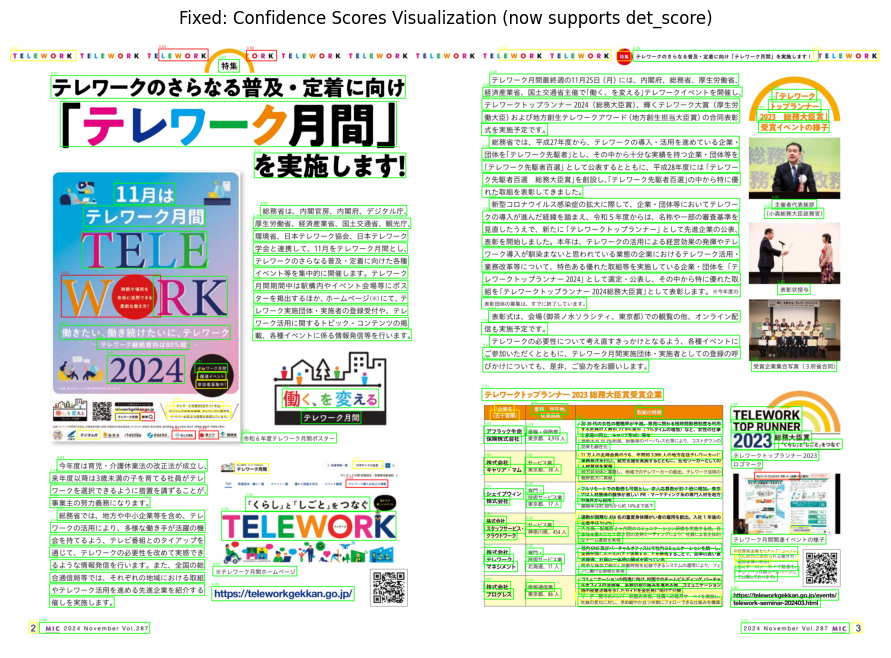

det_scoreを使用して信頼度を可視化


In [18]:
print("=== 信頼度スコアの可視化 ===")

confidence_img_fixed = doc_viz_fixed.visualize_confidence_scores(
    cv2.imread(image),
    img_data[0] if isinstance(img_data, list) else img_data,
    show_ocr_confidence=True,
    show_detection_confidence=False
)

# 元画像と比較して変更があったかチェック
original_img = cv2.imread(image)
if not np.array_equal(confidence_img_fixed, original_img):
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(confidence_img_fixed, cv2.COLOR_BGR2RGB))
    plt.title("Fixed: Confidence Scores Visualization (now supports det_score)")
    plt.axis('off')
    plt.show()
    print("det_scoreを使用して信頼度を可視化")
else:
    print("⚠️ 可視化が適用されませんでした")

=== 要素関係の可視化 ===


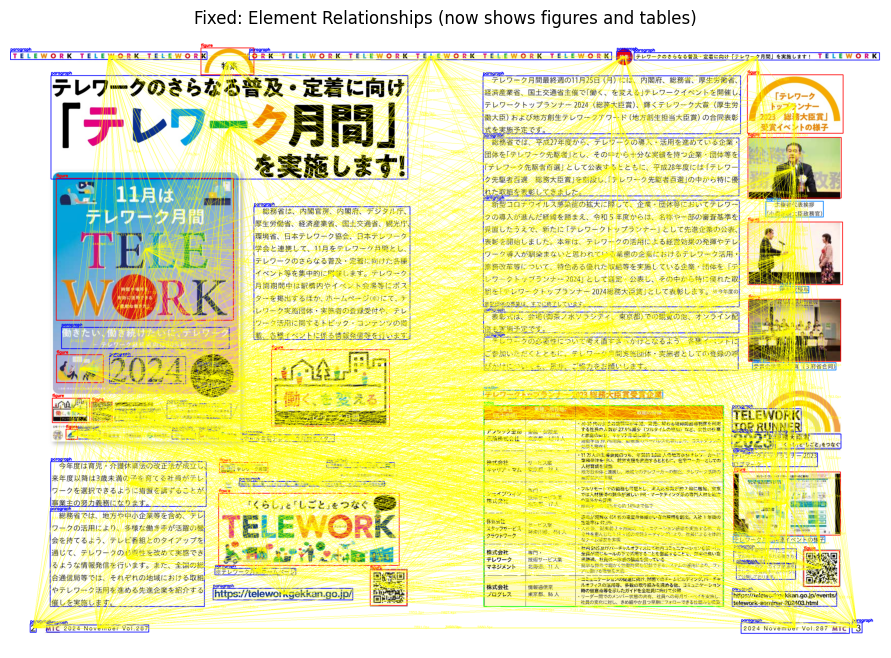

In [19]:
print("=== 要素関係の可視化 ===")

relationship_img_fixed = doc_viz_fixed.visualize_element_relationships(
    cv2.imread(image),
    img_data[0] if isinstance(img_data, list) else img_data,
    show_overlaps=True,
    show_distances=True  # 距離表示
)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(relationship_img_fixed, cv2.COLOR_BGR2RGB))
plt.title("Fixed: Element Relationships (now shows figures and tables)")
plt.axis('off')
plt.show()

=== 要素階層の可視化 ===


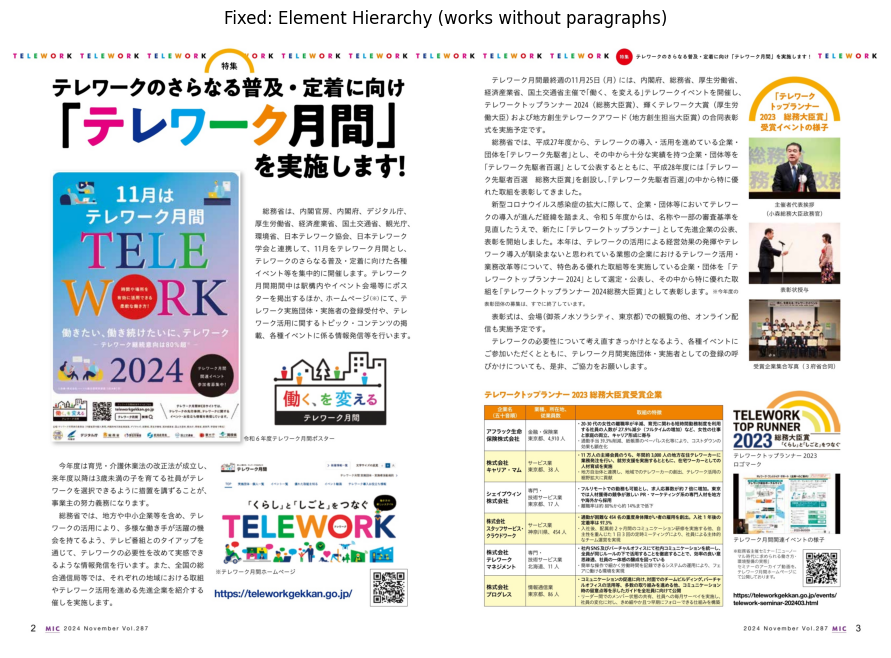

figures/tables/textsの階層関係を表示


In [20]:
print("=== 要素階層の可視化 ===")

hierarchy_img_fixed = doc_viz_fixed.visualize_element_hierarchy(
    cv2.imread(image),
    img_data[0] if isinstance(img_data, list) else img_data,
    show_containment=True,
    containment_threshold=0.5  # 閾値を下げて、より多くの包含関係を検出
)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(hierarchy_img_fixed, cv2.COLOR_BGR2RGB))
plt.title("Fixed: Element Hierarchy (works without paragraphs)")
plt.axis('off')
plt.show()

print("figures/tables/textsの階層関係を表示")